In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from keras import metrics

2023-09-30 14:05:21.316116: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-30 14:05:21.536667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 14:05:22.286194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# data = pd.read_csv("lsa64_dataset_best_80_fps_augmented.csv")

In [2]:
data = pd.read_csv("datasets/lsa64_dataset_openpose_55_frames.csv")

In [3]:
data = data[data["category"] < 11]

In [5]:
data.category.unique()

array([ 1, 10,  2,  3,  4,  5,  6,  7,  8,  9])

In [6]:
frames = 55

In [7]:
def reshape_features_dataset(features):
    return features.reshape((int(features.shape[0]/frames), frames, features.shape[1]))

def reshape_target_dataset(target):
    return target.reshape((int(target.shape[0]/frames), frames))[:, 0]

In [8]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'category', 'video_name', 'frame',
       'hand_0_0_x', 'hand_0_0_y', 'hand_0_0_z', 'hand_0_1_x', 'hand_0_1_y',
       ...
       'pose_22_y', 'pose_22_z', 'pose_23_x', 'pose_23_y', 'pose_23_z',
       'pose_24_x', 'pose_24_y', 'pose_24_z', 'missing_hand', 'missing_face'],
      dtype='object', length=418)

In [9]:
categories = list(data["category"].unique())

In [10]:
data["category_index"] = data["category"].apply(lambda i: categories.index(i))

In [11]:
columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "category", "category_index", "video_name", "frame", "missing_hand", "missing_face", "person"]
# columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "category", "category_index", "video_name", "frame"]
predict_columns = "category_index"

In [12]:
# LOPO
data["person"] = data["video_name"].apply(lambda i: i.split("_")[1])
people = data["person"].unique()
validate_people = people[-2:]
test_people = people[-4:-2]
train_people = people[:-4]

train_dataset = data[data["person"].isin(train_people)]
test_dataset = data[data["person"].isin(test_people)]
validate_dataset = data[data["person"].isin(validate_people)]

# Removing data augmentation for test and validation
test_dataset = test_dataset[(~test_dataset["video_name"].str.contains("augmented"))]
validate_dataset = validate_dataset[(~validate_dataset["video_name"].str.contains("augmented"))]

train_features = train_dataset.drop(columns_to_drop + ["person"], axis=1).values
train_features = reshape_features_dataset(train_features)
train_target = train_dataset[predict_columns].values
train_target = reshape_target_dataset(train_target)

test_features = test_dataset.drop(columns_to_drop + ["person"], axis=1).values
test_features = reshape_features_dataset(test_features)
test_target = test_dataset[predict_columns].values
test_target = reshape_target_dataset(test_target)

validate_features = validate_dataset.drop(columns_to_drop + ["person"], axis=1).values
validate_features = reshape_features_dataset(validate_features)
validate_target = validate_dataset[predict_columns].values
validate_target = reshape_target_dataset(validate_target)

In [49]:
# Train test split
features = data.drop(columns_to_drop, axis=1).values
target = data[predict_columns].values

features = reshape_features_dataset(features)
target = reshape_target_dataset(target)

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.4)

In [13]:
train_features.shape

(300, 55, 411)

In [14]:
test_target.shape

(100,)

In [15]:
model = Sequential()
model.add(LSTM(64, input_shape=(frames, train_features.shape[2]), return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Dense(10, activation='softmax'))

2023-09-30 14:35:31.444674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 14:35:31.465568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 14:35:31.465713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 14:35:31.467716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-30 14:35:31.467877: I tensorflow/compile

In [16]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=1e-5)
# optimizer = optimizers.SGD(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'sparse_categorical_accuracy'])

In [ ]:
# Train the model
result = model.fit(train_features, train_target, epochs=1000, batch_size=32, validation_data=(validate_features, validate_target))

Epoch 1/1000


2023-09-30 14:35:34.961715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-30 14:35:35.072396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-30 14:35:35.074556: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd6f2b34660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-30 14:35:35.074594: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-09-30 14:35:35.077861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-30 14:35:35.212531: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2023-09-30 14:35:35.254757: I ./t

10/10 [==============================] - 4s 68ms/step - loss: 2.3309 - accuracy: 0.0900 - sparse_categorical_accuracy: 0.0900 - val_loss: 2.3179 - val_accuracy: 0.0900 - val_sparse_categorical_accuracy: 0.0900
Epoch 2/1000
10/10 [==============================] - 0s 15ms/step - loss: 2.3353 - accuracy: 0.0800 - sparse_categorical_accuracy: 0.0800 - val_loss: 2.3130 - val_accuracy: 0.0800 - val_sparse_categorical_accuracy: 0.0800
Epoch 3/1000
10/10 [==============================] - 0s 15ms/step - loss: 2.3077 - accuracy: 0.1333 - sparse_categorical_accuracy: 0.1333 - val_loss: 2.3086 - val_accuracy: 0.0700 - val_sparse_categorical_accuracy: 0.0700
Epoch 4/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.3065 - accuracy: 0.1133 - sparse_categorical_accuracy: 0.1133 - val_loss: 2.3048 - val_accuracy: 0.0700 - val_sparse_categorical_accuracy: 0.0700
Epoch 5/1000
10/10 [==============================] - 0s 15ms/step - loss: 2.3083 - accuracy: 0.0833 - sparse_categorical

Epoch 38/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.9421 - accuracy: 0.2967 - sparse_categorical_accuracy: 0.2967 - val_loss: 2.0668 - val_accuracy: 0.2000 - val_sparse_categorical_accuracy: 0.2000
Epoch 39/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.9545 - accuracy: 0.2633 - sparse_categorical_accuracy: 0.2633 - val_loss: 2.0619 - val_accuracy: 0.2000 - val_sparse_categorical_accuracy: 0.2000
Epoch 40/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.9279 - accuracy: 0.2733 - sparse_categorical_accuracy: 0.2733 - val_loss: 2.0486 - val_accuracy: 0.2000 - val_sparse_categorical_accuracy: 0.2000
Epoch 41/1000
10/10 [==============================] - 0s 12ms/step - loss: 1.9331 - accuracy: 0.2733 - sparse_categorical_accuracy: 0.2733 - val_loss: 2.0318 - val_accuracy: 0.2200 - val_sparse_categorical_accuracy: 0.2200
Epoch 42/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.9217 - accuracy: 0.2900 - 

10/10 [==============================] - 0s 14ms/step - loss: 1.5894 - accuracy: 0.4267 - sparse_categorical_accuracy: 0.4267 - val_loss: 1.8490 - val_accuracy: 0.3200 - val_sparse_categorical_accuracy: 0.3200
Epoch 75/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.5845 - accuracy: 0.3900 - sparse_categorical_accuracy: 0.3900 - val_loss: 1.8407 - val_accuracy: 0.3400 - val_sparse_categorical_accuracy: 0.3400
Epoch 76/1000
10/10 [==============================] - 0s 14ms/step - loss: 1.5697 - accuracy: 0.4033 - sparse_categorical_accuracy: 0.4033 - val_loss: 1.8360 - val_accuracy: 0.3500 - val_sparse_categorical_accuracy: 0.3500
Epoch 77/1000
10/10 [==============================] - 0s 14ms/step - loss: 1.5828 - accuracy: 0.3733 - sparse_categorical_accuracy: 0.3733 - val_loss: 1.8416 - val_accuracy: 0.3200 - val_sparse_categorical_accuracy: 0.3200
Epoch 78/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.5530 - accuracy: 0.4033 - sparse_categor

10/10 [==============================] - 0s 14ms/step - loss: 1.1385 - accuracy: 0.6100 - sparse_categorical_accuracy: 0.6100 - val_loss: 1.7309 - val_accuracy: 0.3000 - val_sparse_categorical_accuracy: 0.3000
Epoch 111/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.1483 - accuracy: 0.5800 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.7277 - val_accuracy: 0.2800 - val_sparse_categorical_accuracy: 0.2800
Epoch 112/1000
10/10 [==============================] - 0s 14ms/step - loss: 1.1414 - accuracy: 0.6100 - sparse_categorical_accuracy: 0.6100 - val_loss: 1.7229 - val_accuracy: 0.2900 - val_sparse_categorical_accuracy: 0.2900
Epoch 113/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.1093 - accuracy: 0.6367 - sparse_categorical_accuracy: 0.6367 - val_loss: 1.7092 - val_accuracy: 0.3300 - val_sparse_categorical_accuracy: 0.3300
Epoch 114/1000
10/10 [==============================] - 0s 14ms/step - loss: 1.0877 - accuracy: 0.6267 - sparse_cat

10/10 [==============================] - 0s 13ms/step - loss: 0.8035 - accuracy: 0.7333 - sparse_categorical_accuracy: 0.7333 - val_loss: 1.6088 - val_accuracy: 0.3700 - val_sparse_categorical_accuracy: 0.3700
Epoch 147/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.8017 - accuracy: 0.7167 - sparse_categorical_accuracy: 0.7167 - val_loss: 1.6141 - val_accuracy: 0.3600 - val_sparse_categorical_accuracy: 0.3600
Epoch 148/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.7455 - accuracy: 0.7700 - sparse_categorical_accuracy: 0.7700 - val_loss: 1.5970 - val_accuracy: 0.3800 - val_sparse_categorical_accuracy: 0.3800
Epoch 149/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.7768 - accuracy: 0.7533 - sparse_categorical_accuracy: 0.7533 - val_loss: 1.5892 - val_accuracy: 0.3800 - val_sparse_categorical_accuracy: 0.3800
Epoch 150/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.7657 - accuracy: 0.7200 - sparse_cat

10/10 [==============================] - 0s 13ms/step - loss: 0.5292 - accuracy: 0.8367 - sparse_categorical_accuracy: 0.8367 - val_loss: 1.6681 - val_accuracy: 0.4100 - val_sparse_categorical_accuracy: 0.4100
Epoch 183/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.5871 - accuracy: 0.8133 - sparse_categorical_accuracy: 0.8133 - val_loss: 1.6827 - val_accuracy: 0.3900 - val_sparse_categorical_accuracy: 0.3900
Epoch 184/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.5406 - accuracy: 0.8667 - sparse_categorical_accuracy: 0.8667 - val_loss: 1.6842 - val_accuracy: 0.3900 - val_sparse_categorical_accuracy: 0.3900
Epoch 185/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.5330 - accuracy: 0.8367 - sparse_categorical_accuracy: 0.8367 - val_loss: 1.6815 - val_accuracy: 0.4100 - val_sparse_categorical_accuracy: 0.4100
Epoch 186/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.5297 - accuracy: 0.8367 - sparse_cat

10/10 [==============================] - 0s 12ms/step - loss: 0.3535 - accuracy: 0.9100 - sparse_categorical_accuracy: 0.9100 - val_loss: 1.7197 - val_accuracy: 0.4400 - val_sparse_categorical_accuracy: 0.4400
Epoch 219/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.3587 - accuracy: 0.9300 - sparse_categorical_accuracy: 0.9300 - val_loss: 1.7318 - val_accuracy: 0.4300 - val_sparse_categorical_accuracy: 0.4300
Epoch 220/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.3666 - accuracy: 0.9033 - sparse_categorical_accuracy: 0.9033 - val_loss: 1.7726 - val_accuracy: 0.4000 - val_sparse_categorical_accuracy: 0.4000
Epoch 221/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.3343 - accuracy: 0.9300 - sparse_categorical_accuracy: 0.9300 - val_loss: 1.7524 - val_accuracy: 0.4200 - val_sparse_categorical_accuracy: 0.4200
Epoch 222/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.3374 - accuracy: 0.9233 - sparse_cat

10/10 [==============================] - 0s 12ms/step - loss: 0.2630 - accuracy: 0.9500 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.7197 - val_accuracy: 0.4700 - val_sparse_categorical_accuracy: 0.4700
Epoch 255/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.2547 - accuracy: 0.9500 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.7258 - val_accuracy: 0.4700 - val_sparse_categorical_accuracy: 0.4700
Epoch 256/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.2526 - accuracy: 0.9333 - sparse_categorical_accuracy: 0.9333 - val_loss: 1.7231 - val_accuracy: 0.4600 - val_sparse_categorical_accuracy: 0.4600
Epoch 257/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.2597 - accuracy: 0.9467 - sparse_categorical_accuracy: 0.9467 - val_loss: 1.7534 - val_accuracy: 0.4600 - val_sparse_categorical_accuracy: 0.4600
Epoch 258/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.2572 - accuracy: 0.9400 - sparse_cat

10/10 [==============================] - 0s 13ms/step - loss: 0.1823 - accuracy: 0.9667 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.7234 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 291/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.1872 - accuracy: 0.9633 - sparse_categorical_accuracy: 0.9633 - val_loss: 1.7276 - val_accuracy: 0.4400 - val_sparse_categorical_accuracy: 0.4400
Epoch 292/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1771 - accuracy: 0.9567 - sparse_categorical_accuracy: 0.9567 - val_loss: 1.6980 - val_accuracy: 0.4400 - val_sparse_categorical_accuracy: 0.4400
Epoch 293/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.2222 - accuracy: 0.9567 - sparse_categorical_accuracy: 0.9567 - val_loss: 1.7433 - val_accuracy: 0.4400 - val_sparse_categorical_accuracy: 0.4400
Epoch 294/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.2151 - accuracy: 0.9500 - sparse_cat

10/10 [==============================] - 0s 13ms/step - loss: 0.1434 - accuracy: 0.9733 - sparse_categorical_accuracy: 0.9733 - val_loss: 1.8072 - val_accuracy: 0.4300 - val_sparse_categorical_accuracy: 0.4300
Epoch 327/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.1652 - accuracy: 0.9733 - sparse_categorical_accuracy: 0.9733 - val_loss: 1.8494 - val_accuracy: 0.4600 - val_sparse_categorical_accuracy: 0.4600
Epoch 328/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.1401 - accuracy: 0.9767 - sparse_categorical_accuracy: 0.9767 - val_loss: 1.7691 - val_accuracy: 0.4300 - val_sparse_categorical_accuracy: 0.4300
Epoch 329/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.1346 - accuracy: 0.9833 - sparse_categorical_accuracy: 0.9833 - val_loss: 1.7554 - val_accuracy: 0.4300 - val_sparse_categorical_accuracy: 0.4300
Epoch 330/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.1500 - accuracy: 0.9700 - sparse_cat

10/10 [==============================] - 0s 13ms/step - loss: 0.1147 - accuracy: 0.9867 - sparse_categorical_accuracy: 0.9867 - val_loss: 1.8556 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 363/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1083 - accuracy: 0.9867 - sparse_categorical_accuracy: 0.9867 - val_loss: 1.8002 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 364/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0970 - accuracy: 0.9867 - sparse_categorical_accuracy: 0.9867 - val_loss: 1.7850 - val_accuracy: 0.4400 - val_sparse_categorical_accuracy: 0.4400
Epoch 365/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1112 - accuracy: 0.9867 - sparse_categorical_accuracy: 0.9867 - val_loss: 1.8458 - val_accuracy: 0.4400 - val_sparse_categorical_accuracy: 0.4400
Epoch 366/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.1217 - accuracy: 0.9800 - sparse_cat

10/10 [==============================] - 0s 13ms/step - loss: 0.0731 - accuracy: 0.9900 - sparse_categorical_accuracy: 0.9900 - val_loss: 1.7643 - val_accuracy: 0.4400 - val_sparse_categorical_accuracy: 0.4400
Epoch 399/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.1024 - accuracy: 0.9900 - sparse_categorical_accuracy: 0.9900 - val_loss: 1.7891 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 400/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0849 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.7456 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 401/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0719 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.7599 - val_accuracy: 0.4600 - val_sparse_categorical_accuracy: 0.4600
Epoch 402/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0805 - accuracy: 0.9900 - sparse_cat

10/10 [==============================] - 0s 14ms/step - loss: 0.0728 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.7567 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 435/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0614 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.7907 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 436/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0702 - accuracy: 0.9900 - sparse_categorical_accuracy: 0.9900 - val_loss: 1.7708 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 437/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0571 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.7464 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 438/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0633 - accuracy: 0.9967 - sparse_cat

10/10 [==============================] - 0s 13ms/step - loss: 0.0539 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.7769 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 471/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0589 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.7561 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 472/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.7295 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 473/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0588 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.7471 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 474/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0518 - accuracy: 0.9967 - sparse_cat

10/10 [==============================] - 0s 14ms/step - loss: 0.0391 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.7591 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 507/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0461 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.7506 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 508/1000
10/10 [==============================] - 0s 13ms/step - loss: 0.0353 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.7300 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 509/1000
10/10 [==============================] - 0s 14ms/step - loss: 0.0352 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.7403 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 510/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.0351 - accuracy: 1.0000 - sparse_cat

In [65]:
# Evaluate the model
loss, accuracy, cat_accuracy = model.evaluate(test_features, test_target)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test Caregorial accuracy:', cat_accuracy)

7/7 [==============================] - 0s 30ms/step - loss: 3.0283 - accuracy: 0.5650 - sparse_categorical_accuracy: 0.5650
Test loss: 3.028308391571045
Test accuracy: 0.5649999976158142
Test Caregorial accuracy: 0.5649999976158142


Text(0, 0.5, 'Loss/Accuracy')

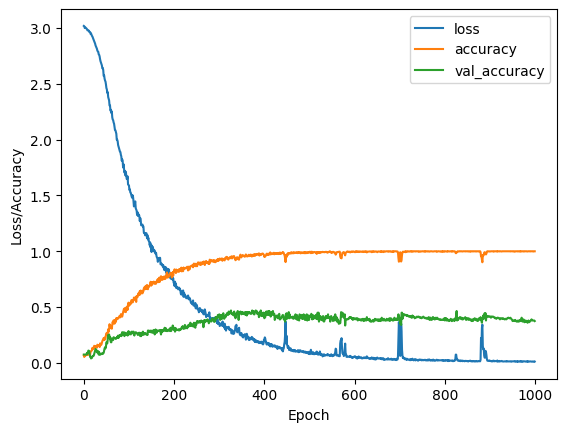

In [66]:
pd.DataFrame.from_dict(result.history)[["loss", "accuracy", "val_accuracy"]].plot()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")

In [27]:
import json

In [34]:
test_features[0].tolist()

[[0.343120664358139,
  0.5942410826683044,
  1.6958705373326668e-07,
  0.3666009306907654,
  0.5847663879394531,
  -0.0093965791165828,
  0.3864558339118957,
  0.560464084148407,
  -0.0134301502257585,
  0.4001175761222839,
  0.5371660590171814,
  -0.0170217305421829,
  0.4129229187965393,
  0.5205081105232239,
  -0.0207169968634843,
  0.3735767006874084,
  0.5041785836219788,
  -0.0063897450454533,
  0.3853523433208465,
  0.4670112133026123,
  -0.012640168890357,
  0.392164796590805,
  0.4441359639167785,
  -0.0183483622968196,
  0.3971493244171142,
  0.4240663051605224,
  -0.0224124696105718,
  0.3596807718276977,
  0.4940334558486938,
  -0.00650041596964,
  0.366813451051712,
  0.4510301649570465,
  -0.0117251751944422,
  0.3711722195148468,
  0.4243792593479156,
  -0.0170082990080118,
  0.3739877641201019,
  0.4033443033695221,
  -0.0207917243242263,
  0.3478835225105285,
  0.4506590962409973,
  -0.0136539964005351,
  0.3499147295951843,
  0.4259508848190307,
  -0.0181813426315784,

In [35]:
json.dumps(test_features[0].tolist())

'[[0.343120664358139, 0.5942410826683044, 1.6958705373326668e-07, 0.3666009306907654, 0.5847663879394531, -0.0093965791165828, 0.3864558339118957, 0.560464084148407, -0.0134301502257585, 0.4001175761222839, 0.5371660590171814, -0.0170217305421829, 0.4129229187965393, 0.5205081105232239, -0.0207169968634843, 0.3735767006874084, 0.5041785836219788, -0.0063897450454533, 0.3853523433208465, 0.4670112133026123, -0.012640168890357, 0.392164796590805, 0.4441359639167785, -0.0183483622968196, 0.3971493244171142, 0.4240663051605224, -0.0224124696105718, 0.3596807718276977, 0.4940334558486938, -0.00650041596964, 0.366813451051712, 0.4510301649570465, -0.0117251751944422, 0.3711722195148468, 0.4243792593479156, -0.0170082990080118, 0.3739877641201019, 0.4033443033695221, -0.0207917243242263, 0.3478835225105285, 0.4506590962409973, -0.0136539964005351, 0.3499147295951843, 0.4259508848190307, -0.0181813426315784, 0.3521099388599396, 0.405885100364685, -0.021040178835392, 0.3312308490276336, 0.50095

In [18]:
predictions = model.predict(test_features)
predictions_category_id = [i.argmax() for i in predictions]

2023-09-13 18:49:07.418921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-13 18:49:07.419833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-13 18:49:07.421026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 17ms/step


In [19]:
df_predictions = pd.DataFrame.from_dict({"category": test_target, "prediction": predictions_category_id})
df_predictions["correct"] = df_predictions["category"] == df_predictions["prediction"]
df_predictions

category  prediction  correct
0          0           0     True
1          0           0     True
2          0           0     True
3          0           0     True
4          0           0     True
..       ...         ...      ...
95         9           9     True
96         9           9     True
97         9           9     True
98         9           9     True
99         9           9     True

[100 rows x 3 columns]

Text(0, 0.5, 'Prediction')

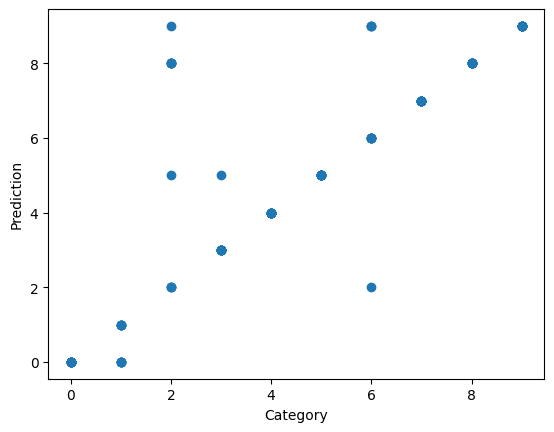

In [20]:
plt.scatter(x=df_predictions["category"], y=df_predictions["prediction"])
plt.xlabel("Category")
plt.ylabel("Prediction")

In [21]:
categories = df_predictions["category"].unique()
categories.sort()
for category in categories:
    df_category = df_predictions[df_predictions["category"] == category]
    correct = len(df_category[df_category["correct"] == True])
    count = len(df_category)
    print(category)
    print("Correct:", correct)
    print("Wrong:", count - correct)
    print("Precision:", correct/count * 100)
    print()

0
Correct: 10
Wrong: 0
Precision: 100.0

1
Correct: 5
Wrong: 5
Precision: 50.0

2
Correct: 3
Wrong: 7
Precision: 30.0

3
Correct: 9
Wrong: 1
Precision: 90.0

4
Correct: 10
Wrong: 0
Precision: 100.0

5
Correct: 10
Wrong: 0
Precision: 100.0

6
Correct: 6
Wrong: 4
Precision: 60.0

7
Correct: 10
Wrong: 0
Precision: 100.0

8
Correct: 10
Wrong: 0
Precision: 100.0

9
Correct: 10
Wrong: 0
Precision: 100.0



In [25]:
# Saving model
model.save("models/asl/model_80_dropout.keras")

In [22]:
# Validation
validation_data = pd.read_csv("validate_dataset.csv")

In [23]:
validation_data

Unnamed: 0  category video_name  frame  hand_0_wrist_x  hand_0_wrist_y  \
0            0         0  hello.mp4      0        0.778732        0.533119   
1            1         0  hello.mp4      1        0.780349        0.531990   
2            2         0  hello.mp4      2        0.789860        0.532102   
3            3         0  hello.mp4      3        0.788924        0.532276   
4            4         0  hello.mp4      4        0.349383        0.268837   
5            5         0  hello.mp4      5        0.785580        0.531081   
6            6         0  hello.mp4      6        0.441508        0.162445   
7            7         0  hello.mp4      7        0.465447        0.166934   
8            8         0  hello.mp4      8        0.471391        0.166036   
9            9         0  hello.mp4      9        0.464834        0.160303   
10          10         0  hello.mp4     10        0.779376        0.531687   
11          11         0  hello.mp4     11        0.779644        0.531685   
12          12         0  hello.mp4     12        0.781791        0.531655   
13          13         0  hello.mp4     13        0.782708        0.531609   
14          14         0  hello.mp4     14        0.782133        0.531865   
15          15         0  hello.mp4     15        0.346353        0.079025   
16          16         0  hello.mp4     16        0.784896        0.531144   
17          17         0  hello.mp4     17        0.461892        0.151870   
18          18         0  hello.mp4     18        0.467716        0.170180   
19          19         0  hello.mp4     19        0.460161        0.179139   
20          20         0  hello.mp4     20        0.783115        0.531644   
21          21         0  hello.mp4     21        0.418891        0.270102   
22          22         0  hello.mp4     22        0.778171        0.532533   
23          23         0  hello.mp4     23        0.405927        0.527840   
24          24         0  hello.mp4     24        0.414584        0.540305   
25          25         0  hello.mp4     25        0.416220        0.536405   
26          26         0  hello.mp4     26        0.416220        0.538796   
27          27         0  hello.mp4     27        0.416620        0.540635   
28          28         0  hello.mp4     28        0.414464        0.539466   
29          29         0  hello.mp4     29        0.408186        0.538940   

    hand_0_wrist_z  hand_0_thumb_cmc_x  hand_0_thumb_cmc_y  \
0     1.618656e-07            0.760882            0.535324   
1     2.006781e-07            0.765526            0.535483   
2     1.953509e-07            0.769175            0.535249   
3     2.103518e-07            0.768380            0.534756   
4     4.599055e-10            0.370172            0.267407   
5     2.303617e-07            0.761963            0.533857   
6     1.070640e-07            0.467898            0.163019   
7     1.335545e-07            0.497158            0.169014   
8     1.390416e-07            0.500977            0.170404   
9     1.670441e-07            0.493160            0.164720   
10    2.479295e-07            0.758172            0.535488   
11    2.445497e-07            0.758079            0.535335   
12    2.421798e-07            0.758349            0.535317   
13    2.463044e-07            0.758703            0.535151   
14    2.455174e-07            0.758071            0.534575   
15    3.153196e-08            0.371749            0.074185   
16    2.408095e-07            0.761879            0.534450   
17    5.661589e-08            0.485591            0.156236   
18    6.843580e-08            0.497625            0.173046   
19    1.020952e-07            0.487769            0.181526   
20    2.446014e-07            0.759649            0.534867   
21    5.739671e-08            0.440521            0.260766   
22    2.344880e-07            0.754864            0.536402   
23    8.516432e-08            0.426821            0.535840   
24    5.811830e-08            0.440

In [24]:
validation_data = validation_data.drop(["Unnamed: 0", "category", "video_name", "frame"], axis=1).values

In [45]:
validation_data = validation_data.reshape((int(validation_data.shape[0]/frames), frames, validation_data.shape[1]))

In [46]:
validation_data.shape

(1, 30, 1623)

In [47]:
result = model.predict(validation_data)

1/1 [==============================] - 0s 17ms/step


In [50]:
result.argmax()

3